In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import networkx as nx

import gseapy as gp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

os.makedirs("../data/fig2-3/gsea", exist_ok=True)
os.makedirs("../data/fig2-3/pagerank", exist_ok=True)

## Breast cancer

In [4]:
condition = "Breast cancer"

# 1. Load gene-gene interactions from BioREX database
relations_df = pd.read_csv("../data/fig2-3/all_human_gene_interactions_2024-12-18.csv")

# 2. Calculate context-dependent weights
relations_df["pair"] = relations_df.apply(lambda x: "--".join(sorted([str(x["from_gene"]), str(x["to_gene"])])), axis=1)
relations_df = relations_df.drop_duplicates(subset=["pmid", "pair"]).reset_index(drop=True)

# 3. Load corretion between PMIDs and BERT embeddings
# You have to calculate correlation in advance and ensure that "condition" is included in the column names.
threshold = 0.1
pmid_corrs = pd.read_parquet("../data/fig2-3/Repr_diseases_pmid_bert_corrs.parquet")[["pmid", condition]]

relations_df["corr"] = relations_df["pmid"].map(pmid_corrs.set_index("pmid")[condition])
relations_df = relations_df.dropna(subset=["corr"]).reset_index(drop=True)
# Thresholding
relations_df = relations_df[relations_df["corr"] > threshold].reset_index(drop=True)
print("Number of interactions after thresholding:", len(relations_df))

relations_df = relations_df[["pair", "corr"]].groupby("pair").agg({"corr": "sum"}).reset_index()
# normalize counts per million
relations_df["corr"] = relations_df["corr"] / relations_df["corr"].sum() * 1e6
# Log transformation to make the distribution more normal
relations_df["corr"] = np.log1p(relations_df["corr"].values)
# rename
relations_df.columns = ["pair", "weight"]

# 4. Create a graph
edges = [(pair.split("--")[0], pair.split("--")[1], count) for pair, count in zip(relations_df["pair"], relations_df["weight"])]
G = nx.Graph()
G.add_weighted_edges_from(edges)

n_nodes = len(G.nodes)
n_edges = len(G.edges)
density = nx.density(G)
print("--- Step 1 ---")
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Density: {density}")

# 5. Extract connected components
connected_components = list(nx.connected_components(G))
size_connected_components = [len(c) for c in connected_components]
# Extract the largest connected component
main_subgraph = G.subgraph(connected_components[np.argmax(size_connected_components)]).copy()
gene_ids = np.array(list(main_subgraph.nodes))
n_nodes = len(main_subgraph.nodes)
n_edges = len(main_subgraph.edges)
density = nx.density(main_subgraph)
print("--- Step 2 (After extracting largest connected component) ---")
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Density: {density}")

Number of interactions after thresholding: 1056390
--- Step 1 ---
Number of nodes: 17976
Number of edges: 427041
Density: 0.002643246164101974
--- Step 2 (After extracting largest connected component) ---
Number of nodes: 17920
Number of edges: 427008
Density: 0.0026595871899739304


In [5]:
# 6. Degree penalization to deal with scale-free property
# Compute degree penalty matrix W
def get_degree_penalty_matrix(graph, beta):
    # D = sp.diags([degree for _, degree in graph.degree(weight="weight")]) # sparse
    D = sp.diags([degree for _, degree in graph.degree()]) # sparse
    C = get_common_neighbor_matrix(graph) + nx.adjacency_matrix(graph)  # C' = C + A
    D_inv_beta = sp.diags(np.power(np.array(D.diagonal()), -beta))  # D^-beta
    W = D_inv_beta.T @ C @ D_inv_beta  # W = (D^-beta)^T C' (D^-beta)
    return W

def get_common_neighbor_matrix(graph):
    A = nx.adjacency_matrix(graph) # sparse
    C = A.T @ A - sp.diags((A.T @ A).diagonal())  # C = A^T A - diag(A^T A)
    return C

beta = 1.0
W = get_degree_penalty_matrix(main_subgraph, beta)
DP_adj = W.toarray() * nx.adjacency_matrix(main_subgraph, weight="weight").toarray()

# update graph
nodes2idx = {node: idx for idx, node in enumerate(main_subgraph.nodes)}
for u, v in main_subgraph.edges():
    main_subgraph[u][v]["weight"] = DP_adj[nodes2idx[u], nodes2idx[v]]

In [6]:
# 7. PageRank
pagerank = nx.pagerank(main_subgraph)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
sorted_pagerank = pd.DataFrame(sorted_pagerank, columns=["gene", "pagerank"])
sorted_pagerank.to_csv("../data/fig2-3/pagerank/pagerank_breast_cancer.csv", index=False)
print("=====", "Pagerank", "=====")
print(sorted_pagerank.head(10))

===== Pagerank =====
     gene  pagerank
0    AKT1  0.002812
1    TP53  0.002556
2   ERBB2  0.002102
3   NFKB1  0.002020
4    EGFR  0.001939
5    ESR1  0.001931
6   TGFB1  0.001927
7   MAPK1  0.001921
8  CTNNB1  0.001861
9     MYC  0.001623


In [7]:
top10_genes = sorted_pagerank["gene"].values[:10]

nodes_in_paths = set(top10_genes)
for source in top10_genes:
    for target in top10_genes:
        if source != target:
            path = nx.shortest_path(main_subgraph, source=source, target=target)
            nodes_in_paths.update(path)

top10_subgraph = main_subgraph.subgraph(nodes_in_paths).copy()
top10_subgraph_dataframe = nx.to_pandas_edgelist(top10_subgraph)
display(top10_subgraph_dataframe.head(10))
display(top10_subgraph_dataframe.shape)

# save
top10_subgraph_pagerank_dataframe = sorted_pagerank[sorted_pagerank["gene"].isin(top10_subgraph.nodes)].reset_index(drop=True)
top10_subgraph_dataframe.to_csv("../data/fig2-3/pagerank/top10_subgraph_breast_cancer.csv", index=False)
top10_subgraph_pagerank_dataframe.to_csv("../data/fig2-3/pagerank/top10_subgraph_pagerank_breast_cancer.csv", index=False)

,source,target,weight
0,CTNNB1,AKT1,0.001868
1,CTNNB1,NFKB1,0.001338
2,CTNNB1,EGFR,0.001736
3,CTNNB1,ERBB2,0.001914
4,CTNNB1,ESR1,0.001568
5,CTNNB1,MAPK1,0.001218
6,CTNNB1,MYC,0.002196
7,CTNNB1,TGFB1,0.001687
8,CTNNB1,TP53,0.001480
9,TGFB1,AKT1,0.002061


(45, 3)

2025-07-20 14:16:50,611 [WARNING] Duplicated values found in preranked stats: 1.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-20 14:16:50,611 [INFO] Parsing data files for GSEA.............................
2025-07-20 14:16:50,625 [INFO] Enrichr library gene sets already downloaded in: /home/masato-tsutsui/.cache/gseapy, use local file
2025-07-20 14:16:50,631 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-07-20 14:16:50,632 [INFO] 0050 gene_sets used for further statistical testing.....
2025-07-20 14:16:50,632 [INFO] Start to run GSEA...Might take a while..................
2025-07-20 14:16:52,082 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Apoptosis,0.845323,2.04737,0.0,0.0,0.0,94/161,6.99%,ERBB2;CTNNB1;TNF;BRCA1;CCND1;IL6;EREG;CASP3;MM...
1,prerank,PI3K/AKT/mTOR Signaling,0.826193,1.971633,0.0,0.0,0.0,56/104,7.94%,AKT1;EGFR;MAPK1;PTEN;MAPK8;CDKN1A;GSK3B;E2F1;C...
2,prerank,Allograft Rejection,0.804853,1.962553,0.0,0.0,0.0,104/198,9.89%,AKT1;EGFR;TGFB1;TNF;BRCA1;IL6;EREG;HIF1A;MMP9;...
3,prerank,TNF-alpha Signaling via NF-kB,0.78406,1.915492,0.0,0.0,0.0,97/198,8.39%,NFKB1;MYC;TNF;VEGFA;CCND1;IL6;CDKN1A;CD44;JUN;...
4,prerank,IL-6/JAK/STAT3 Signaling,0.802576,1.910711,0.0,0.0,0.0,49/87,8.90%,TGFB1;STAT3;TNF;IL6;CD44;JUN;IL1B;FAS;STAT1;CS...
5,prerank,TGF-beta Signaling,0.810688,1.893687,0.0,0.0,0.0,35/54,11.21%,TGFB1;CTNNB1;CDH1;SMAD3;RHOA;JUNB;SERPINE1;APC...
6,prerank,Wnt-beta Catenin Signaling,0.816973,1.893416,0.0,0.0,0.0,25/42,10.06%,TP53;CTNNB1;MYC;NOTCH1;SKP2;ADAM17;DKK1;JAG1;H...
7,prerank,Notch Signaling,0.811251,1.878647,0.0,0.0,0.0,18/32,8.39%,CCND1;NOTCH1;PRKCA;WNT5A;NOTCH3;JAG1;CUL1;TCF7...
8,prerank,Epithelial Mesenchymal Transition,0.758573,1.835203,0.0,0.0,0.0,94/197,9.69%,TGFB1;VEGFA;IL6;MMP2;VIM;CD44;JUN;CXCL8;CDH2;S...
9,prerank,G2-M Checkpoint,0.746673,1.829729,0.0,0.0,0.0,123/199,15.16%,TGFB1;MYC;CCND1;HIF1A;EGF;MAPK14;ABL1;EZH2;BRC...


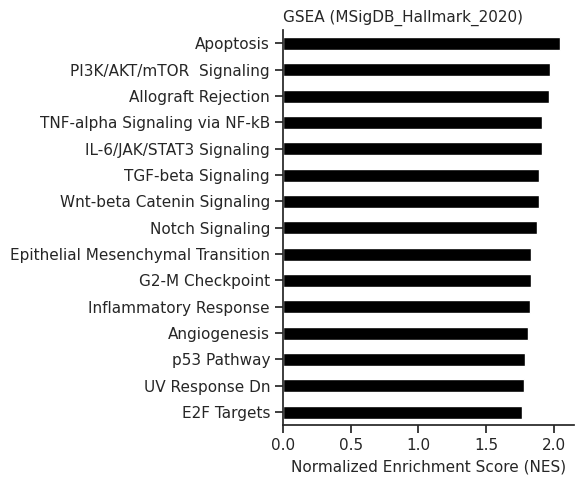

In [10]:
# GSEApy
rnk = sorted_pagerank.set_index("gene").copy()
pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets="MSigDB_Hallmark_2020",
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=42,
                     verbose=True, # see what's going on behind the scenes
                    )
pre_res.res2d.sort_values("NES", ascending=False).to_csv("../data/fig2-3/gsea/gsea_breast_cancer_results.csv", index=False)

display(pre_res.res2d.sort_values("NES", ascending=False).head(15))

# Plot
plt_df = pre_res.res2d.sort_values("NES", ascending=False).head(15).copy()

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=plt_df, x="NES", y="Term", ax=ax, color="black", width=0.5)
ax.set_xlabel("Normalized Enrichment Score (NES)", fontsize=11)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_title("GSEA (MSigDB_Hallmark_2020)", loc="left", fontsize=11)
fig.tight_layout()
fig.savefig("../data/fig2-3/gsea/gsea_breast_cancer.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## Type2 Diabete

In [11]:
condition = "Type 2 diabetes"

# 1. Load gene-gene interactions from BioREX database
relations_df = pd.read_csv("../data/fig2-3/all_human_gene_interactions_2024-12-18.csv")

# 2. Calculate context-dependent weights
relations_df["pair"] = relations_df.apply(lambda x: "--".join(sorted([str(x["from_gene"]), str(x["to_gene"])])), axis=1)
relations_df = relations_df.drop_duplicates(subset=["pmid", "pair"]).reset_index(drop=True)

# 3. Load corretion between PMIDs and BERT embeddings
# You have to calculate correlation in advance and ensure that "condition" is included in the column names.
threshold = 0.1
pmid_corrs = pd.read_parquet("../data/fig2-3/Repr_diseases_pmid_bert_corrs.parquet")[["pmid", condition]]

relations_df["corr"] = relations_df["pmid"].map(pmid_corrs.set_index("pmid")[condition])
relations_df = relations_df.dropna(subset=["corr"]).reset_index(drop=True)
# Thresholding
relations_df = relations_df[relations_df["corr"] > threshold].reset_index(drop=True)
print("Number of interactions after thresholding:", len(relations_df))

relations_df = relations_df[["pair", "corr"]].groupby("pair").agg({"corr": "sum"}).reset_index()
# normalize counts per million
relations_df["corr"] = relations_df["corr"] / relations_df["corr"].sum() * 1e6
# Log transformation to make the distribution more normal
relations_df["corr"] = np.log1p(relations_df["corr"].values)
# rename
relations_df.columns = ["pair", "weight"]

# 4. Create a graph
edges = [(pair.split("--")[0], pair.split("--")[1], count) for pair, count in zip(relations_df["pair"], relations_df["weight"])]
G = nx.Graph()
G.add_weighted_edges_from(edges)

n_nodes = len(G.nodes)
n_edges = len(G.edges)
density = nx.density(G)
print("--- Step 1 ---")
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Density: {density}")

# 5. Extract connected components
connected_components = list(nx.connected_components(G))
size_connected_components = [len(c) for c in connected_components]
# Extract the largest connected component
main_subgraph = G.subgraph(connected_components[np.argmax(size_connected_components)]).copy()
gene_ids = np.array(list(main_subgraph.nodes))
n_nodes = len(main_subgraph.nodes)
n_edges = len(main_subgraph.edges)
density = nx.density(main_subgraph)
print("--- Step 2 (After extracting largest connected component) ---")
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Density: {density}")

Number of interactions after thresholding: 1156577
--- Step 1 ---
Number of nodes: 17910
Number of edges: 445149
Density: 0.0027756741157347405
--- Step 2 (After extracting largest connected component) ---
Number of nodes: 17865
Number of edges: 445122
Density: 0.002789506159609521


In [12]:
# 6. Degree penalization to deal with scale-free property
# Compute degree penalty matrix W
def get_degree_penalty_matrix(graph, beta):
    # D = sp.diags([degree for _, degree in graph.degree(weight="weight")]) # sparse
    D = sp.diags([degree for _, degree in graph.degree()]) # sparse
    C = get_common_neighbor_matrix(graph) + nx.adjacency_matrix(graph)  # C' = C + A
    D_inv_beta = sp.diags(np.power(np.array(D.diagonal()), -beta))  # D^-beta
    W = D_inv_beta.T @ C @ D_inv_beta  # W = (D^-beta)^T C' (D^-beta)
    return W

def get_common_neighbor_matrix(graph):
    A = nx.adjacency_matrix(graph) # sparse
    C = A.T @ A - sp.diags((A.T @ A).diagonal())  # C = A^T A - diag(A^T A)
    return C

beta = 1.0
W = get_degree_penalty_matrix(main_subgraph, beta)
DP_adj = W.toarray() * nx.adjacency_matrix(main_subgraph, weight="weight").toarray()

# update graph
nodes2idx = {node: idx for idx, node in enumerate(main_subgraph.nodes)}
for u, v in main_subgraph.edges():
    main_subgraph[u][v]["weight"] = DP_adj[nodes2idx[u], nodes2idx[v]]

In [16]:
# 7. PageRank
pagerank = nx.pagerank(main_subgraph)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
sorted_pagerank = pd.DataFrame(sorted_pagerank, columns=["gene", "pagerank"])
sorted_pagerank.to_csv("../data/fig2-3/pagerank/pagerank_diabetes.csv", index=False)
print("=====", "Pagerank", "=====")
print(sorted_pagerank.head(10))

===== Pagerank =====
    gene  pagerank
0    INS  0.002492
1   AKT1  0.002016
2    TNF  0.001796
3  TGFB1  0.001512
4  MAPK1  0.001498
5  NFKB1  0.001477
6   IFNG  0.001364
7    IL6  0.001358
8    AGT  0.001313
9   IL1B  0.001253


In [15]:
top10_genes = sorted_pagerank["gene"].values[:10]

nodes_in_paths = set(top10_genes)
for source in top10_genes:
    for target in top10_genes:
        if source != target:
            path = nx.shortest_path(main_subgraph, source=source, target=target)
            nodes_in_paths.update(path)

top10_subgraph = main_subgraph.subgraph(nodes_in_paths).copy()
top10_subgraph_dataframe = nx.to_pandas_edgelist(top10_subgraph)
display(top10_subgraph_dataframe.head(10))
display(top10_subgraph_dataframe.shape)

# save
top10_subgraph_pagerank_dataframe = sorted_pagerank[sorted_pagerank["gene"].isin(top10_subgraph.nodes)].reset_index(drop=True)
top10_subgraph_dataframe.to_csv("../data/fig2-3/pagerank/top10_subgraph_diabetes.csv", index=False)
top10_subgraph_pagerank_dataframe.to_csv("../data/fig2-3/pagerank/top10_subgraph_pagerank_diabetes.csv", index=False)

,source,target,weight
0,IL1B,AKT1,0.001654
1,IL1B,MAPK1,0.001918
2,IL1B,AGT,0.002840
3,IL1B,IFNG,0.002879
4,IL1B,IL6,0.003361
5,IL1B,INS,0.002788
6,IL1B,NFKB1,0.003100
7,IL1B,TGFB1,0.001843
8,IL1B,TNF,0.003311
9,TGFB1,AKT1,0.001913


(45, 3)

2025-07-20 14:19:51,762 [WARNING] Duplicated values found in preranked stats: 0.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-20 14:19:51,763 [INFO] Parsing data files for GSEA.............................
2025-07-20 14:19:51,777 [INFO] Enrichr library gene sets already downloaded in: /home/masato-tsutsui/.cache/gseapy, use local file
2025-07-20 14:19:51,783 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-07-20 14:19:51,784 [INFO] 0050 gene_sets used for further statistical testing.....
2025-07-20 14:19:51,784 [INFO] Start to run GSEA...Might take a while..................
2025-07-20 14:19:53,243 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Pancreas Beta Cells,0.86623,2.075796,0.0,0.0,0.0,26/39,8.33%,INS;GCG;FOXO1;PDX1;SST;DPP4;IAPP;VDR;SLC2A2;GC...
1,prerank,Allograft Rejection,0.806426,2.049732,0.0,0.0,0.0,108/198,9.11%,AKT1;TNF;TGFB1;IFNG;IL6;IL1B;CD4;CD8A;HIF1A;IL...
2,prerank,PI3K/AKT/mTOR Signaling,0.811113,2.024739,0.0,0.0,0.0,55/104,7.53%,AKT1;MAPK1;MAPK8;IL4;EGFR;GSK3B;PRKAA2;PTEN;CD...
3,prerank,Apoptosis,0.793074,2.009393,0.0,0.0,0.0,81/161,6.47%,TNF;IL6;IL1B;CTNNB1;APP;CASP3;ERBB2;IFNB1;BAX;...
4,prerank,IL-6/JAK/STAT3 Signaling,0.798621,1.960277,0.0,0.0,0.0,50/87,8.98%,TNF;TGFB1;IL6;IL1B;STAT3;TLR2;JUN;STAT1;PTPN11...
5,prerank,TNF-alpha Signaling via NF-kB,0.750875,1.915726,0.0,0.0,0.0,99/199,11.02%,TNF;NFKB1;IL6;IL1B;VEGFA;NFE2L2;MYC;CCL2;CCND1...
6,prerank,TGF-beta Signaling,0.792676,1.901631,0.0,0.0,0.0,31/54,10.36%,TGFB1;CTNNB1;CDH1;SMAD3;SERPINE1;BMP2;RHOA;JUN...
7,prerank,Inflammatory Response,0.734651,1.869027,0.0,0.0,0.0,100/200,11.47%,NFKB1;IL6;IL1B;HIF1A;IL10;MYC;NLRP3;CCL2;TLR2;...
8,prerank,Interferon Gamma Response,0.730693,1.863339,0.0,0.0,0.0,91/197,12.12%,NFKB1;IL6;HIF1A;STAT3;CASP3;CCL2;CDKN1A;CD274;...
9,prerank,Wnt-beta Catenin Signaling,0.762229,1.83132,0.0,0.0,0.0,22/42,10.08%,TP53;CTNNB1;MYC;PPARD;NOTCH1;SKP2;DKK1;ADAM17;...


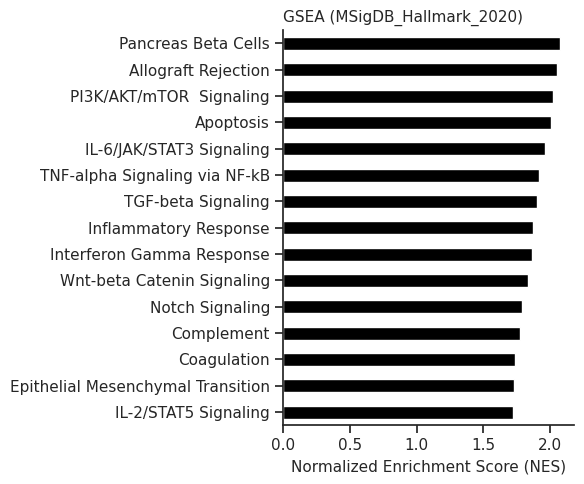

In [17]:
# GSEApy
rnk = sorted_pagerank.set_index("gene").copy()
pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets="MSigDB_Hallmark_2020",
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=42,
                     verbose=True, # see what's going on behind the scenes
                    )
pre_res.res2d.sort_values("NES", ascending=False).to_csv("../data/fig2-3/gsea/gsea_diabetes_results.csv", index=False)

display(pre_res.res2d.sort_values("NES", ascending=False).head(15))

# Plot
plt_df = pre_res.res2d.sort_values("NES", ascending=False).head(15).copy()

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=plt_df, x="NES", y="Term", ax=ax, color="black", width=0.5)
ax.set_xlabel("Normalized Enrichment Score (NES)", fontsize=11)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_title("GSEA (MSigDB_Hallmark_2020)", loc="left", fontsize=11)
fig.tight_layout()
fig.savefig("../data/fig2-3/gsea/gsea_diabetes.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)